In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
%cd /content/drive/MyDrive/paper_5_cvpr/notebooks/3_video_feature_similarity_confusion_matrix/visil/
!ls

/content/drive/MyDrive/paper_5_cvpr/notebooks/3_video_feature_similarity_confusion_matrix/visil
calculate_similarity.py  datasets	LICENSE    requirements.txt
ckpt			 Dockerfile	model	   results.json
ckpt.zip		 evaluation.py	query.txt  video_4_fs.csv
database.txt		 examples	README.md  video_similarity.png


In [ ]:
!python calculate_similarity.py --query_file query.txt --database_file database.txt --model_dir ckpt/resnet/

In [ ]:
import json
import argparse
import tensorflow as tf
import numpy as np

from tqdm import tqdm
from model.visil import ViSiL
from datasets import VideoGenerator

# Input Paremeters
query_file = 'query.txt'
network = 'resnet'
threads = 8
model_dir = 'ckpt/resnet'
load_queries = 'store_true'
similarity_function = 'chamfer'
batch_sz = 128
database_file = 'database.txt'
gpu_id = 0
output_file = 'results.json'

# Create a video generator for the queries
enqueuer = tf.keras.utils.OrderedEnqueuer(VideoGenerator(query_file, all_frames='i3d' in network),
                                          use_multiprocessing=True, shuffle=False)
enqueuer.start(workers=threads, max_queue_size=threads*2)
generator = enqueuer.get()

# Initialize ViSiL model
model = ViSiL(model_dir, net=network, load_queries=load_queries, gpu_id=gpu_id, similarity_function=similarity_function,
              queries_number=len(enqueuer.sequence) if load_queries else None)

In [ ]:
# Create a video generator for the queries
enqueuer = tf.keras.utils.OrderedEnqueuer(VideoGenerator(query_file, all_frames='i3d' in network),
                                          use_multiprocessing=True, shuffle=False)
enqueuer.start(workers=threads, max_queue_size=threads*2)
generator = enqueuer.get()

# Extract features of the queries
queries, queries_ids = [], []
pbar = tqdm(range(len(enqueuer.sequence)))
for _ in pbar:
    frames, video_id = next(generator)
    features = model.extract_features(frames, batch_sz)
    queries.append(features)
    queries_ids.append(video_id)
    pbar.set_postfix(query_id=video_id)
enqueuer.stop()

model.set_queries(queries)

# Create a video generator for the database video
enqueuer = tf.keras.utils.OrderedEnqueuer(VideoGenerator(database_file, all_frames='i3d' in network),
                                          use_multiprocessing=True, shuffle=False)
enqueuer.start(workers=threads, max_queue_size=threads*2)
generator = enqueuer.get()

# Calculate similarities between the queries and the database videos
similarities = dict({query: dict() for query in queries_ids})
pbar = tqdm(range(len(enqueuer.sequence)))

similarity_matrix = []

for _ in pbar:
    frames, video_id = next(generator)
    if frames.shape[0] > 1:
        features = model.extract_features(frames, batch_sz)
        sims = model.calculate_similarities_to_queries(features)

        for i, s in enumerate(sims):
             similarities[queries_ids[i]][video_id] = float(s)
             similarity_matrix.append(float(s))
        pbar.set_postfix(video_id=video_id)
enqueuer.stop()

# Save similarities to a json file
with open(output_file, 'w') as f:
    # json.dump(similarities, f, indent=1)
    similarity_matrix = np.reshape(similarity_matrix, (5, 5))
    # print
    # print(similarity_matrix)
    # for video_1, video_2 in enumerate(similarities):
    #     print(similarities)

100%|██████████| 5/5 [00:06<00:00,  1.38s/it, query_id=3_angle_5]


100%|██████████| 5/5 [00:06<00:00,  1.27s/it, video_id=3_angle_5]


In [ ]:
print(similarity_matrix)

[[ 0.89343917  0.79338837  0.01572843 -0.41918787  0.78036171]
 [ 0.8079145   0.95631385  0.79793864 -0.0613651   0.68215042]
 [ 0.19261809  0.80834335  0.96045965  0.18657911  0.50550914]
 [-0.56463355  0.10896488  0.00679262  0.91318518 -0.02305137]
 [ 0.73911387  0.52910393  0.16025536 -0.15580554  0.88525087]]


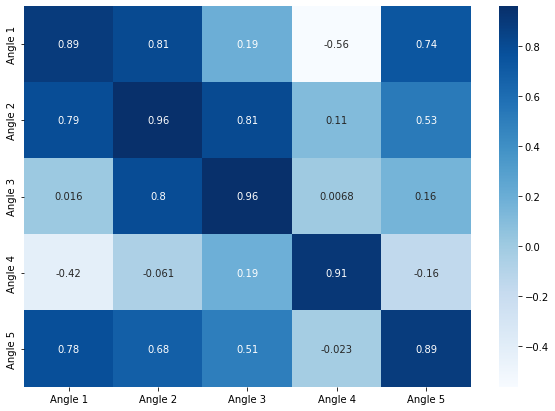

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = np.transpose(similarity_matrix)
df_cm = pd.DataFrame(array, index = [i for i in ["Angle 1", "Angle 2", "Angle 3", "Angle 4", "Angle 5"]],
                  columns = [i for i in ["Angle 1", "Angle 2", "Angle 3", "Angle 4", "Angle 5"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')

# np.savetxt("video_4_fs.csv", array, delimiter=",", fmt="%.2e")

In [ ]:
similarities

{'4_angle_1': {'4_angle_1': 0.8766494393348694,
  '4_angle_2': -0.13169251382350922,
  '4_angle_3': -0.20157648622989655,
  '4_angle_4': -0.653191864490509,
  '4_angle_5': -0.937004029750824},
 '4_angle_2': {'4_angle_1': -0.18025068938732147,
  '4_angle_2': 0.874733030796051,
  '4_angle_3': 0.7502796053886414,
  '4_angle_4': -0.24289937317371368,
  '4_angle_5': -0.8710586428642273},
 '4_angle_3': {'4_angle_1': -0.17286090552806854,
  '4_angle_2': 0.7010430693626404,
  '4_angle_3': 0.8848638534545898,
  '4_angle_4': -0.08025523275136948,
  '4_angle_5': -0.7715150117874146},
 '4_angle_4': {'4_angle_1': -0.8030051589012146,
  '4_angle_2': -0.1255214363336563,
  '4_angle_3': -0.05450635775923729,
  '4_angle_4': 0.8950921893119812,
  '4_angle_5': -0.7352739572525024},
 '4_angle_5': {'4_angle_1': -0.9069408774375916,
  '4_angle_2': -0.6612839698791504,
  '4_angle_3': -0.6159989237785339,
  '4_angle_4': -0.7040810585021973,
  '4_angle_5': 0.8958288431167603}}

In [ ]:
anchor_sequence = []
anchor_sequence.append(["Angle_1", (np.sum(array[0]) - (array[0][0]))/4.0])
anchor_sequence.append(["Angle_2", (np.sum(array[1]) - (array[1][1]))/4.0])
anchor_sequence.append(["Angle_3", (np.sum(array[2]) - (array[2][2]))/4.0])
anchor_sequence.append(["Angle_4", (np.sum(array[3]) - (array[3][3]))/4.0])
anchor_sequence.append(["Angle_5", (np.sum(array[4]) - (array[4][4]))/4.0])

print(anchor_sequence)

def sortSecond(val):
    return val[1]

anchor_sequence.sort(key = sortSecond, reverse = True) 
print(anchor_sequence)

[['Angle_1', 0.2937532253563404], ['Angle_2', 0.5599501319229603], ['Angle_3', 0.24517876259051263], ['Angle_4', -0.1124448524788022], ['Angle_5', 0.4862424759194255]]
[['Angle_2', 0.5599501319229603], ['Angle_5', 0.4862424759194255], ['Angle_1', 0.2937532253563404], ['Angle_3', 0.24517876259051263], ['Angle_4', -0.1124448524788022]]


In [ ]:
import random

list_Size = 200
# random float from 1 to 99.9
integer_list = random.sample(range(0, 1), list_Size)
float_list = [x/10 for x in integer_list]
print(float_list)
# Output [7.9, 84.6, 72.1, 92.9, 64.1, 2.8, 32.6, 36.9, 97.4, 64.4]

ValueError: ignored

In [ ]:
my_array = np.random.random((5, 5))
my_array[0][0] = 1
my_array[1][1] = 1
my_array[2][2] = 1
my_array[3][3] = 1
my_array[4][4] = 1
my_array.sort(key=lambda x: x[1])

TypeError: ignored

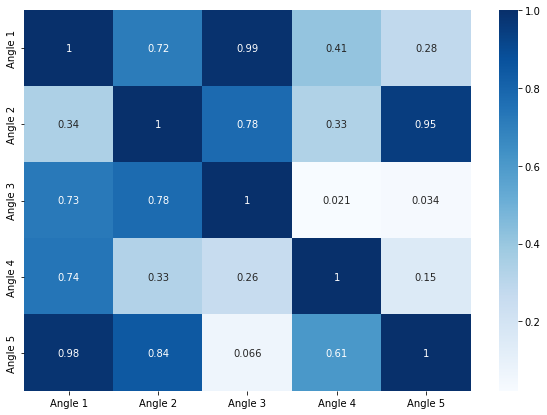

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(my_array, index = [i for i in ["Angle 1", "Angle 2", "Angle 3", "Angle 4", "Angle 5"]],
                  columns = [i for i in ["Angle 1", "Angle 2", "Angle 3", "Angle 4", "Angle 5"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')

#Array operations

In [1]:
import numpy as np
import random

In [146]:
wow = np.random.uniform(0.60, 0.92, (5,5))
wow

array([[0.67878683, 0.87457888, 0.89879389, 0.68445146, 0.64720882],
       [0.65344925, 0.76103848, 0.6553857 , 0.75041637, 0.83479714],
       [0.78751907, 0.87397713, 0.7147088 , 0.73727843, 0.74142281],
       [0.63433626, 0.74497745, 0.9114777 , 0.72607377, 0.74912147],
       [0.83895921, 0.66959756, 0.64823729, 0.76949453, 0.69485025]])

In [147]:
wow[0][0] = 0.95
wow[1][1] = 0.94
wow[2][2] = 0.95
wow[3][3] = 0.95
wow[4][4] = 0.94  

In [159]:
i, j, value = 4, 2, 0.80
wow[i][j] = value
wow[j][i] = value

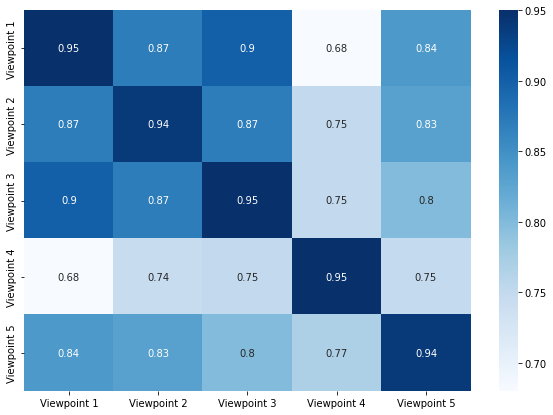

In [161]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(wow, index = [i for i in ["Viewpoint 1", "Viewpoint 2", "Viewpoint 3", "Viewpoint 4", "Viewpoint 5"]],
                  columns = [i for i in ["Viewpoint 1", "Viewpoint 2", "Viewpoint 3", "Viewpoint 4", "Viewpoint 5"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')
np.savetxt("sample_5.csv", wow, delimiter=",", fmt="%.2e")
plt.savefig('sample_5_matrix.svg', dpi = 600)

In [162]:
anchor_sequence = []
anchor_sequence.append(["Angle_1", (np.sum(wow[0]) - (wow[0][0]))/4.0])
anchor_sequence.append(["Angle_2", (np.sum(wow[1]) - (wow[1][1]))/4.0])
anchor_sequence.append(["Angle_3", (np.sum(wow[2]) - (wow[2][2]))/4.0])
anchor_sequence.append(["Angle_4", (np.sum(wow[3]) - (wow[3][3]))/4.0])
anchor_sequence.append(["Angle_5", (np.sum(wow[4]) - (wow[4][4]))/4.0])

print(anchor_sequence)

def sortSecond(val):
    return val[1]

anchor_sequence.sort(key = sortSecond, reverse = True) 
print(anchor_sequence)

[['Angle_1', 0.8225], ['Angle_2', 0.8301040921073978], ['Angle_3', 0.8299999999999998], ['Angle_4', 0.7310247296259114], ['Angle_5', 0.8098736334317617]]
[['Angle_2', 0.8301040921073978], ['Angle_3', 0.8299999999999998], ['Angle_1', 0.8225], ['Angle_5', 0.8098736334317617], ['Angle_4', 0.7310247296259114]]


In [78]:
ooo = np.genfromtxt('sample_1.csv', dtype=float, delimiter=',')
ooo

array([[0.97 , 0.801, 0.74 , 0.69 , 0.85 ],
       [0.811, 0.92 , 0.69 , 0.751, 0.78 ],
       [0.74 , 0.69 , 0.97 , 0.778, 0.8  ],
       [0.69 , 0.712, 0.738, 0.95 , 0.804],
       [0.85 , 0.78 , 0.8  , 0.702, 0.92 ]])